In [1]:
# System imports
import os
import sys
sys.path.append("../")

# Standard imports
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt

# Dataset imports
from keras.datasets import mnist

# Project library imports
from modules.deltavae.deltavae_latent_spaces import deltavae_sphere, deltavae_clifford_torus, deltavae_torus_r3, deltavae_o3, deltavae_so3, deltavae_o3, deltavae_rpd, stdvae
from modules.deltavae.deltavae_latent_spaces import deltavae_parameters
from modules.deltavae.encoder_decoder_architectures.encoder import encoder_dense
from modules.deltavae.encoder_decoder_architectures.decoder import decoder_dense
from modules.experiment_control import experiment_class, experiment_parameters
from modules.utils.data import dataset_creation




Using TensorFlow backend.


# Binary MNIST training
This notebook shows a sample script for the training of the $\Delta$VAE using the binary MNIST dataset. 

## Import MNIST dataset

In [2]:
# load data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# Normalize images to [0,1]
x_train = dataset_creation.normalize_images(x_train)
x_test = dataset_creation.normalize_images(x_test)
# Binarize each pixel and add channel 
x_train = dataset_creation.binarize(x_train, 0)
x_test = dataset_creation.binarize(x_test, 0)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

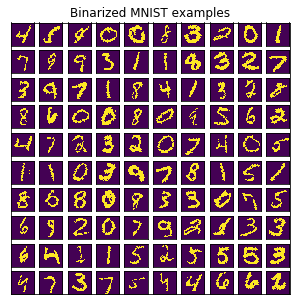

In [3]:
# Plot random binarized MNIST numbers
fig = plt.figure(figsize = (5,5))
plt.title("Binarized MNIST examples")
plt.xticks([])
plt.yticks([])

for i in range(100):
    ax = fig.add_subplot(10,10,i+1)
    ax.imshow(x_train[np.random.randint(0,len(x_train)),:,:,0])
    ax.set_xticks([])
    ax.set_yticks([])


## Parameters for training the $\Delta$VAE

Uncomment the manifold of your choice to train with the corresponding latent space. 

In [4]:
# Manifold choice 
manifold = "hypersphere_d"
#manifold = "clifford_torus"
#manifold = "torus_r3"
#manifold = "o3"
#manifold = "so3"
#manifold = "rp_d"
#manifold = "standard"

# Network parameters
H_DIM = 128 # Hidden state size
#if manifold == "hypersphere":
    
D = 2 # Latent space degrees of freedom
UNCONSTRAINED_T = False
BATCH_NORMALIZATION = False
CONTROLLED_CAPACITY = False
DECODER_OUTPUT_ACTIVATION = "sigmoid" # activation function for reconstruction


# Training parameters
EPOCHS = 100
BATCH_SIZE = 100

VAR_X = 1.0 
R_LOSS = "binary" # reconstruction loss


## Definition of network architecture

In [5]:
# # # # # # # # # # ENCODER # # # # # # # # # #
encoder_dict = {"input_shape": x_train.shape[1:],
                "unconstrained_t": UNCONSTRAINED_T,
                "dense_units_list":[H_DIM*2, H_DIM],
                "batch_normalization": BATCH_NORMALIZATION
                }
encoder_class = encoder_dense.EncoderDense(**encoder_dict)

# # # # # # # # # # DECODER # # # # # # # # # #
decoder_dict = {"input_shape": x_train.shape[1:],
                "dense_units_list":[H_DIM*2, H_DIM],
                "batch_normalization": BATCH_NORMALIZATION,
                "decoder_output_activation": DECODER_OUTPUT_ACTIVATION
                }
decoder_class = decoder_dense.DecoderDense(**decoder_dict)

# # # # # # # # # # Delta-VAE # # # # # # # # # #
vae_params_dict = {"d": D,
                   "var_x": VAR_X,
                   "controlled_capacity":CONTROLLED_CAPACITY,
                   "r_loss": R_LOSS,
                   "optimizer": keras.optimizers.Adam()
                       }
diff_vae_params = deltavae_parameters.DiffusionVAEParams(**vae_params_dict)

# Build the appropriate DeltaVAE
if manifold == "hypersphere_d":
    vae = deltavae_sphere.DiffusionSphereVAE(diff_vae_params, encoder_class, decoder_class)
elif manifold == "clifford_torus":
    vae = deltavae_clifford_torus.DiffusionFlatTorusVAE(diff_vae_params, encoder_class, decoder_class)
elif manifold == "torus_r3":
    vae = deltavae_torus_r3.DiffusionTorusR3(diff_vae_params, encoder_class, decoder_class)
elif manifold == "o3":
    vae = deltavae_o3.DiffusionO3VAE(diff_vae_params, encoder_class, decoder_class)
elif manifold == "so3":
    vae = deltavae_so3.DiffusionSO3VAE(diff_vae_params, encoder_class, decoder_class)
elif manifold == "rp_d":
    vae = deltavae_rpd.DiffusionRPNVAE(diff_vae_params, encoder_class, decoder_class)
elif manifold == "standard":
    vae = stdvae.StandardVAE(diff_vae_params, encoder_class, decoder_class)
else:
    vae = None



W0329 15:22:19.695650 25496 deprecation_wrapper.py:119] From C:\Users\s161416\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0329 15:22:19.702028 25496 deprecation_wrapper.py:119] From C:\Users\s161416\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0329 15:22:19.724783 25496 deprecation_wrapper.py:119] From C:\Users\s161416\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0329 15:22:19.887379 25496 deprecation.py:506] From ..\modules\deltavae\deltavae_latent_spaces\deltavae_sphere.py:79: calling l2_normalize (from tensorflow.python.ops.nn_impl) with dim

Log time between -7.5 and -5.0
Encoder built


W0329 15:22:20.565042 25496 deprecation_wrapper.py:119] From C:\Users\s161416\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0329 15:22:20.575031 25496 deprecation_wrapper.py:119] From ..\modules\deltavae\deltavae_latent_spaces\deltavae_parent.py:221: The name tf.log is deprecated. Please use tf.math.log instead.



Decoder built
Reconstruction loss is binary cross entropy
Reconstruction loss is binary cross entropy
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 784)          0           encoder_input[0][0]              
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          200960      flatten_1[0][0]                  
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 256)          0           dense_1[0][0]                    
_______

## Experiment definition and training

In [6]:
########### EXPERIMENT CLASS ###########
# Experiment class
training_params_dict = {"epochs": EPOCHS,
                        "batch_size": BATCH_SIZE}
train_vae_params = experiment_parameters.ExperimentParams(**training_params_dict)
experiment_path = os.path.join(os.getcwd(), "results") # saving path for experiments
exp = experiment_class.Experiment(vae, train_vae_params, x_train, experiment_path)

# Start training
exp.run_vae()




C:\Users\s161416\Documents\GitHub\diffusion_vae_github\notebooks\results\tensorboard\2020-03-29-15-22_


W0329 15:22:24.592643 25496 deprecation.py:323] From C:\Users\s161416\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0329 15:22:28.308609 25496 deprecation_wrapper.py:119] From C:\Users\s161416\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\keras\callbacks.py:850: The name tf.summary.merge_all is deprecated. Please use tf.compat.v1.summary.merge_all instead.

W0329 15:22:28.309597 25496 deprecation_wrapper.py:119] From C:\Users\s161416\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\keras\callbacks.py:853: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.



Epoch 1/100
 - 10s - loss: 190.0607 - kl_loss: 4.7002 - r_loss: 185.3606 - mean_squared_error: 0.0776
Epoch 2/100
 - 8s - loss: 159.2292 - kl_loss: 5.0137 - r_loss: 154.2155 - mean_squared_error: 0.0645
Epoch 3/100
 - 8s - loss: 154.2757 - kl_loss: 5.5444 - r_loss: 148.7313 - mean_squared_error: 0.0619
Epoch 4/100
 - 8s - loss: 151.4676 - kl_loss: 5.7438 - r_loss: 145.7239 - mean_squared_error: 0.0605
Epoch 5/100
 - 8s - loss: 149.2605 - kl_loss: 5.8841 - r_loss: 143.3764 - mean_squared_error: 0.0594
Epoch 6/100
 - 8s - loss: 147.6013 - kl_loss: 5.9994 - r_loss: 141.6019 - mean_squared_error: 0.0586
Epoch 7/100
 - 8s - loss: 146.2526 - kl_loss: 6.0764 - r_loss: 140.1762 - mean_squared_error: 0.0579
Epoch 8/100
 - 8s - loss: 146.3685 - kl_loss: 6.1403 - r_loss: 140.2282 - mean_squared_error: 0.0579
Epoch 9/100
 - 8s - loss: 144.4706 - kl_loss: 6.2082 - r_loss: 138.2624 - mean_squared_error: 0.0571
Epoch 10/100
 - 9s - loss: 144.1078 - kl_loss: 6.2551 - r_loss: 137.8526 - mean_squared_er

Epoch 82/100
 - 8s - loss: 134.2485 - kl_loss: 7.0744 - r_loss: 127.1741 - mean_squared_error: 0.0522
Epoch 83/100
 - 8s - loss: 134.3051 - kl_loss: 7.0711 - r_loss: 127.2340 - mean_squared_error: 0.0522
Epoch 84/100
 - 7s - loss: 134.2735 - kl_loss: 7.0692 - r_loss: 127.2043 - mean_squared_error: 0.0522
Epoch 85/100
 - 8s - loss: 134.7206 - kl_loss: 7.0900 - r_loss: 127.6306 - mean_squared_error: 0.0524
Epoch 86/100
 - 8s - loss: 134.3017 - kl_loss: 7.0802 - r_loss: 127.2215 - mean_squared_error: 0.0522
Epoch 87/100
 - 8s - loss: 135.5146 - kl_loss: 7.0851 - r_loss: 128.4295 - mean_squared_error: 0.0527
Epoch 88/100
 - 8s - loss: 135.7604 - kl_loss: 7.0859 - r_loss: 128.6744 - mean_squared_error: 0.0528
Epoch 89/100
 - 8s - loss: 134.5165 - kl_loss: 7.0956 - r_loss: 127.4209 - mean_squared_error: 0.0523
Epoch 90/100
 - 8s - loss: 134.6152 - kl_loss: 7.0994 - r_loss: 127.5157 - mean_squared_error: 0.0524
Epoch 91/100
 - 8s - loss: 133.9644 - kl_loss: 7.1117 - r_loss: 126.8526 - mean_sq

Text(0.5, 0.92, 'Latent space embedding ')

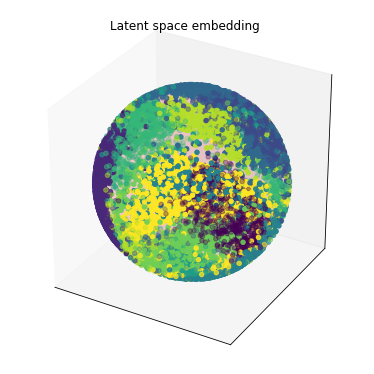

In [7]:
__, ax = vae.save_plot_latent_space(x_test, y_test, 100 , None)
plt.title(r"Latent space embedding ")

Text(0.5, 1.0, 'Reconstruction of digit images')

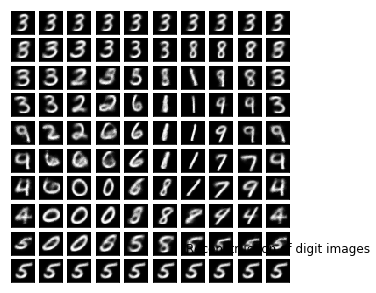

In [8]:
vae.save_plot_image_reconstruction(100, None, 10);
plt.title(r"Reconstruction of digit images")